In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import mobilenet

In [2]:

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPU


In [4]:
test_path = r'C:\Users\bhave\Desktop\plant\datas\test_final'
train_path = r'C:\Users\bhave\Desktop\plant\datas\train350'
valid_path = r'C:\Users\bhave\Desktop\plant\datas\valid150'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input, rescale=1./255).flow_from_directory(directory=train_path, target_size=(224,224), shuffle=True,class_mode='categorical')
valid_batches = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input, rescale=1./255).flow_from_directory(directory=valid_path, target_size=(224,224), shuffle=True, class_mode='categorical')
test_batches = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input, rescale=1./255).flow_from_directory(directory=test_path, target_size=(224,224), shuffle=False, class_mode='categorical')

Found 11550 images belonging to 33 classes.
Found 4950 images belonging to 33 classes.
Found 33 images belonging to 33 classes.


In [6]:
train_batches.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Cherry_(including_sour)___Powdery_mildew': 4,
 'Cherry_(including_sour)___healthy': 5,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 6,
 'Corn_(maize)___Common_rust_': 7,
 'Corn_(maize)___Northern_Leaf_Blight': 8,
 'Corn_(maize)___healthy': 9,
 'Grape___Black_rot': 10,
 'Grape___Esca_(Black_Measles)': 11,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 12,
 'Grape___healthy': 13,
 'Peach___Bacterial_spot': 14,
 'Peach___healthy': 15,
 'Pepper,_bell___Bacterial_spot': 16,
 'Pepper,_bell___healthy': 17,
 'Potato___Early_blight': 18,
 'Potato___Late_blight': 19,
 'Potato___healthy': 20,
 'Strawberry___Leaf_scorch': 21,
 'Strawberry___healthy': 22,
 'Tomato___Bacterial_spot': 23,
 'Tomato___Early_blight': 24,
 'Tomato___Late_blight': 25,
 'Tomato___Leaf_Mold': 26,
 'Tomato___Septoria_leaf_spot': 27,
 'Tomato___Spider_mites Two-spotted_spider_mite': 28,
 'Tomato___Target_Spot'

In [7]:
print(train_batches.num_classes,
valid_batches.num_classes)

33 33


In [8]:
mobileload = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [9]:
#Pre-tuned MobileNet model
mobileload.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [10]:
x = mobileload.layers[-6].output
x = Flatten()(x)
x = Dropout(0.15)(x)
output = Dense(units=33, activation='softmax')(x)
model = Model(inputs=mobileload.input, outputs=output)


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [12]:
for layer in mobileload.layers[:-30]:
    layer.trainable = False

mobileload.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [13]:
custom_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00025)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(x=train_batches ,epochs=30, batch_size=64, verbose=1)

Epoch 1/30
361/361 [==============================] - 19s 42ms/step - loss: 4.0881 - accuracy: 0.2597
Epoch 2/30
361/361 [==============================] - 15s 42ms/step - loss: 1.9554 - accuracy: 0.5312
Epoch 3/30
 41/361 [==>...........................] - ETA: 13s - loss: 1.3552 - accuracy: 0.6265

KeyboardInterrupt: 

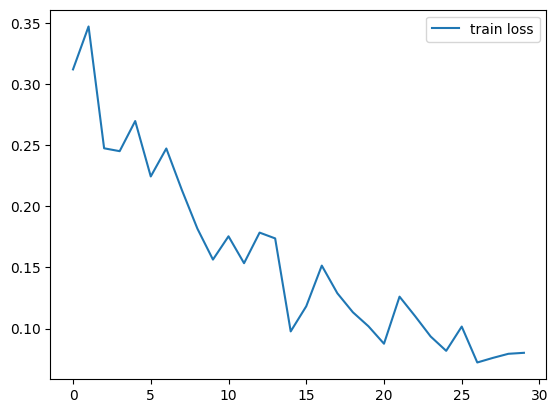

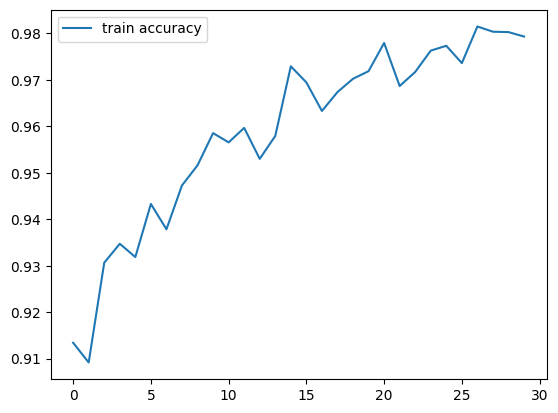

In [ ]:
plt.plot(history.history['loss'], label='train loss')
# plt.plot(history.history['val_loss'], label='val loss')

plt.legend()
plt.show()


plt.plot(history.history['accuracy'], label='train accuracy')
# plt.plot(history.history['val_accuracy'], label='val accuracy')

plt.legend()
plt.show()

In [ ]:
# model.save('4mobilenet.h5')

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

In [ ]:
# test_labels = test_batches.classes

# test_predictions = model.predict(x=test_batches, verbose=2)

In [ ]:
test_loss, test_acc = model.evaluate(test_batches,verbose=2)
print('\nTest accuracy:', test_acc)

2/2 - 0s - loss: 4.4145 - accuracy: 0.6061 - 462ms/epoch - 231ms/step

Test accuracy: 0.6060606241226196
